# <center>**`CUSTOMER CHURN PREDICTION FOR POWERCO`**</center>

___
# <center>**PROBLEM AND APPROACH**</center>
___

## **PROBLEM** 
PowerCo, a major player in the energy sector, is facing rising customer churn. The company hypothesizes that **`price sensitivity`** specifically fluctuations between peak and off-peak energy pricing may be a significant driver of this churn. The challenge is to determine whether price sensitivity is indeed the primary cause of customer attrition and to predict which customers are most likely to leave in the future.

## **APPROACH**
In this analysis, we will undertake a comprehensive exploratory data analysis (EDA) to delve into the underlying data, identify patterns, and gain insights related to customer churn. Our approach includes the following steps:
1. Conduct EDA to understand the data and uncover patterns associated with churn.
2. Develop new features that we believe will enhance our ability to predict churn.
3. Utilize machine learning techniques to assess churn likelihood and pinpoint key factors influencing churn,with a particular emphasis on investigating if **`price sensitivity`** is a significant determinant.
4. Examine specific cases to understand why certain companies either remained with the service or opted to churn.

___
# <center>**ANALYSIS & FINDINGS**</center>
___

## **IMPORTING PACKAGES AND LOADING DATA**

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import joblib
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report,make_scorer,f1_score,accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Initializing basic parameters like style of the plots & other dataframe options that allow us to see all the columns and rows
sns.set_style(style='whitegrid')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [85]:
client_df = pd.read_csv("Data/client_data.csv")
price_df = pd.read_csv("Data/price_data.csv")

___
## **EXPLORATORY DATA ANALYSIS**

### BASIC STRUCTURE

In [86]:
print(f'Shape of Price Dataset: {price_df.shape[0]} rows & {price_df.shape[1]} columns')
print(f'Shape of Client Dataset: {client_df.shape[0]} rows & {client_df.shape[1]} columns')

Shape of Price Dataset: 193002 rows & 8 columns
Shape of Client Dataset: 14606 rows & 26 columns


In [87]:
# First few rows 
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.00,1.78,0.11,0.10,40.61,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.65,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.00,16.27,0.15,0.00,44.31,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.80,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.00,38.72,0.17,0.09,44.31,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.86,0


In [88]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.15,0.00,0.00,44.27,0.00,0.00
1,038af19179925da21a25619c5a24b745,2015-02-01,0.15,0.00,0.00,44.27,0.00,0.00
2,038af19179925da21a25619c5a24b745,2015-03-01,0.15,0.00,0.00,44.27,0.00,0.00


Based on the shape analysis and view,we can see that the client data contains static information about individual clients,where each row represents a single client.The price data,on the other hand, has around 193,000 rows, suggesting data entries over time for each customer,probably a time series data.

Note: We will combine these datasets later after the EDA process.


### NULL CHECK

In [89]:
print(f'Null values in Client dataset: {client_df.isna().sum().sum()}')
print(f'Null values in Price dataset: {price_df.isna().sum().sum()}')

Null values in Client dataset: 0
Null values in Price dataset: 0


### DATA TYPES

In [90]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [91]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


Pandas does not automatically recognize date columns as datetime format, so we need to manually convert them during data manipulation to ensure proper handling of date-related operations.

### DESCRIPTIVE STATISTICS


In [92]:
# The describe method provides key summary statistics such as mean, median, mode, quantiles, and standard deviations.
client_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00
mean,159220.29,28092.38,16090.27,1868.61,1399.76,0.97,63.09,0.14,0.05,43.13,152.79,24.57,24.56,1.29,189.26,5.00,18.14,0.10
std,573465.26,162973.06,64364.20,2387.57,3247.79,5.11,66.17,0.02,0.05,4.49,341.37,20.23,20.23,0.71,311.80,1.61,13.53,0.30
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,3.30,0.00
25%,5674.75,0.00,0.00,495.00,0.00,0.00,16.18,0.12,0.00,40.61,0.00,14.28,14.28,1.00,50.71,4.00,12.50,0.00
50%,14115.50,0.00,792.50,1112.88,314.00,0.00,18.80,0.14,0.08,44.31,37.39,21.64,21.64,1.00,112.53,5.00,13.86,0.00
75%,40763.75,0.00,3383.00,2401.79,1745.75,0.00,131.03,0.15,0.10,44.31,193.98,29.88,29.88,1.00,243.10,6.00,19.17,0.00
max,6207104.00,4154590.00,771203.00,82902.83,175375.00,30.00,599.31,0.27,0.20,59.27,15042.79,374.64,374.64,32.00,24570.65,13.00,320.00,1.00


The data appears to be highly skewed, as indicated by the large distance between quantile values and the high ratio of the standard deviation to the mean, which highlights significant skewness. 

For example, the standard deviation in 12 months of consumption is nearly five times the average value.

In [93]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.00,193002.00,193002.00,193002.00,193002.00,193002.00
mean,0.14,0.05,0.03,43.33,10.62,6.41
std,0.03,0.05,0.04,5.41,12.84,7.77
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.13,0.00,0.00,40.73,0.00,0.00
50%,0.15,0.09,0.00,44.27,0.00,0.00
75%,0.15,0.10,0.07,44.44,24.34,16.23
max,0.28,0.23,0.11,59.44,36.49,17.46


The peak season fixed price shows a high variablity with std around 120% of means and seems to concentrated in upper quartile due to median being 0, overall the fixed prieces across all seaons seems to be less spreaded than the variable price.



___
## **DATA VISUALIZATION**

In [94]:
# Creating a function to plot annoted bar charts

def AnnotedBars(df,title,size=(12,6),rotation=0):
    """
    Plot the stacked bar chart
    """
    ax = df.plot(kind='bar',
            stacked=True,
            figsize=size,
            color=['Lightgreen','red']
    )
    # Calling the annotate function to annot the bars
    Annotate(ax)
    plt.legend(['Stayed','Churned'])
    plt.title(title,fontweight='bold')
    plt.yticks(rotation=rotation)
    plt.ylabel('Base(%)')
    plt.show()

def Annotate(ax):
        """
        Annotate the stacked bar chart
        """
        for patch in ax.patches:
            value = str(round(patch.get_height(),1))


            # Since there is no need to plot 0% valus we are skipping that
            if value == '0.0':
                continue
            ax.annotate(value,
                        xy=((patch.get_x() + patch.get_width()/2),
                            (patch.get_y() + patch.get_height()/2) * 0.99)
                            ,rotation=90)

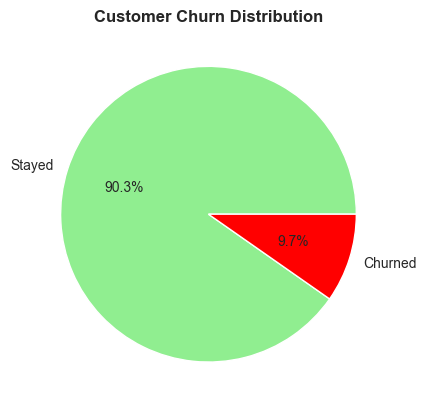

In [95]:
churn_counts = client_df['churn'].value_counts()
labels = churn_counts.index.map({0:'Stayed',1:'Churned'})
plt.pie(churn_counts,labels=labels,autopct='%1.1f%%',colors=['lightgreen','red'])
plt.title('Customer Churn Distribution',fontweight='bold')
plt.show()


Almost 10% of customers has churned around out of all

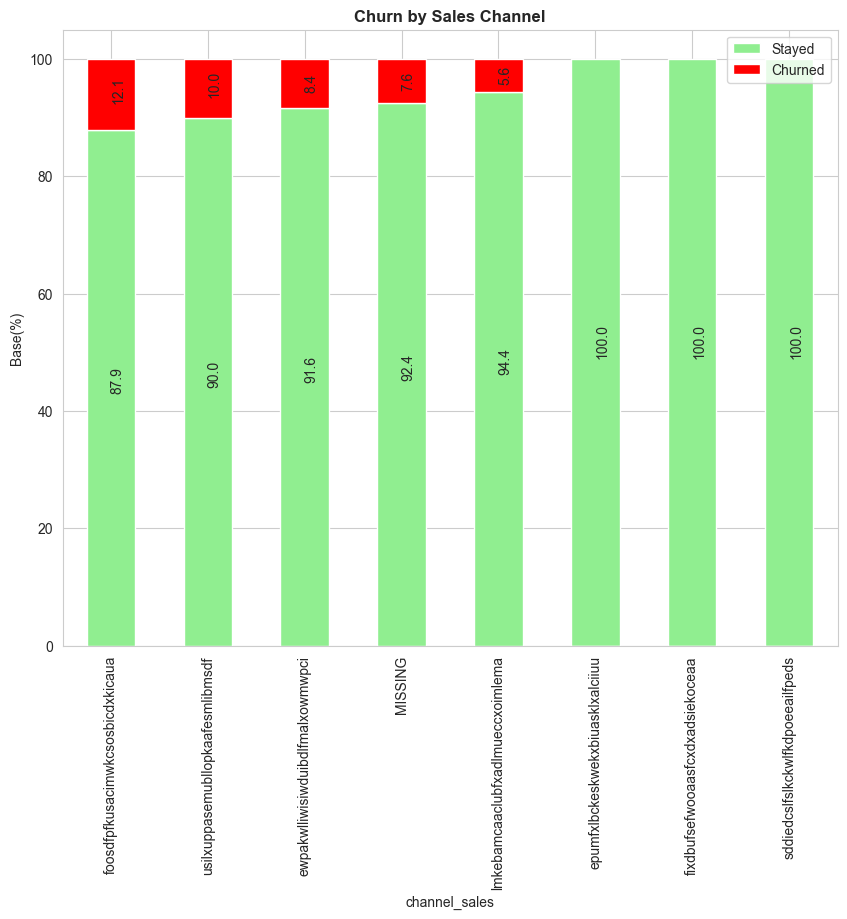

In [96]:
channel = client_df[['id', 'channel_sales', 'churn']]
channel = channel.groupby([channel['channel_sales'], channel['churn']])['id'].count().unstack(level=1).fillna(0)
channel_churn = (channel.div(channel.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)
AnnotedBars(channel_churn,title='Churn by Sales Channel',size=(10,8))



In [97]:
client_df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

The churn is distribute around 5 sales channel with highest that of 'foosdfpfkusacimwkcsosbicdxkicaua',another important channel is the one labeled as 'MISSING' Probably added to handle the unknowon or null values.

### CONSUMPTION PATTERN

In [98]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]


Since we already know from the statistics that the data is highly skewed, we will use a boxplot as it clearly displays skewness, outliers, and the spread of the data

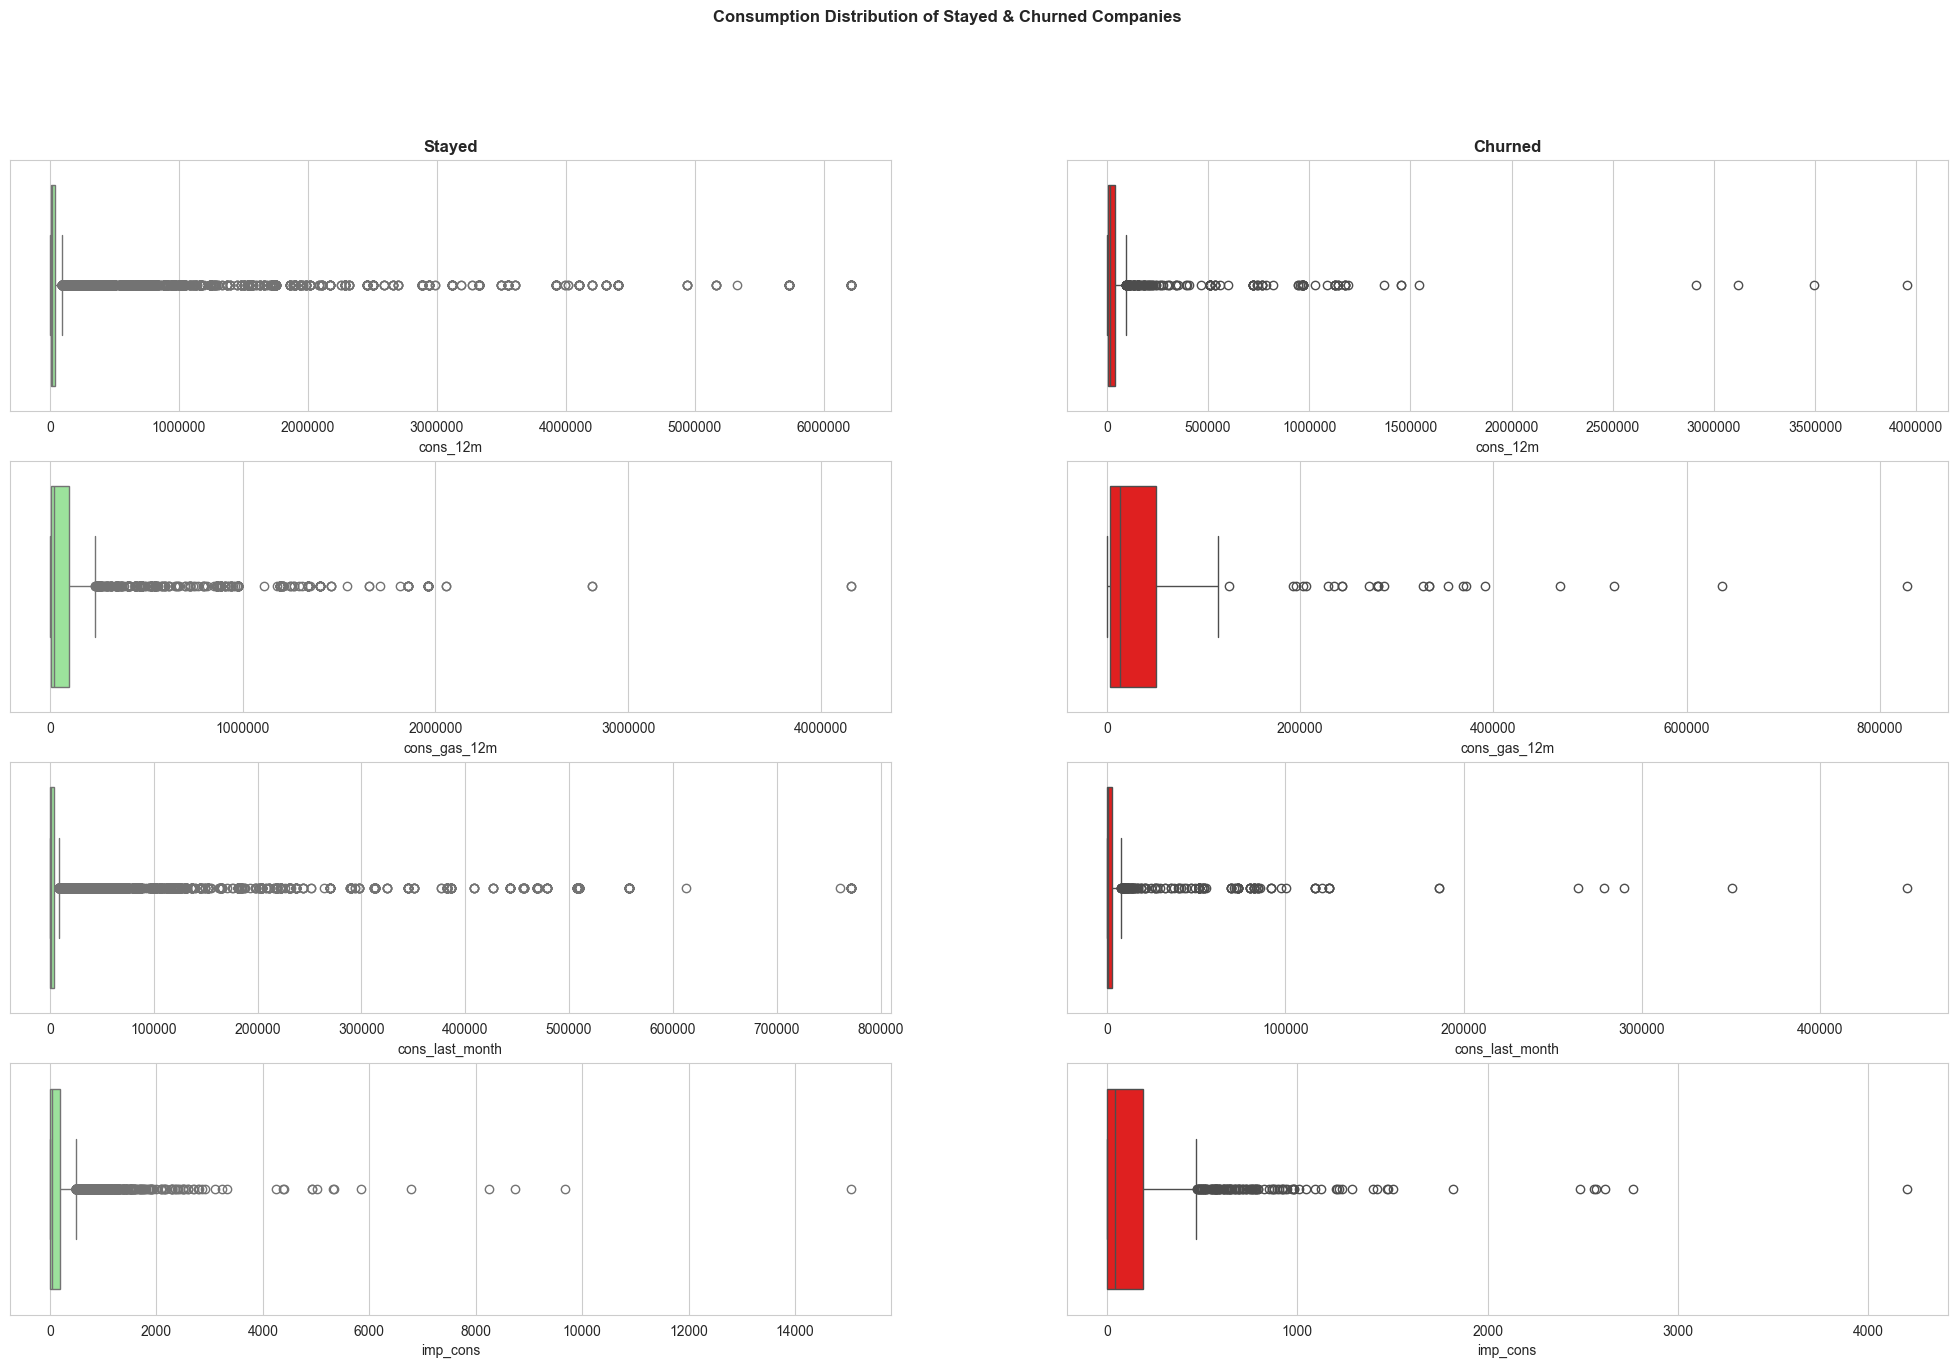

In [99]:
consumption = client_df[['cons_12m','cons_gas_12m','cons_last_month','imp_cons','has_gas','churn']]
fig, axs = plt.subplots(nrows=4,ncols=2,figsize=(25,15))

# Plot histogram
sns.boxplot(consumption.loc[consumption['churn'] == 0]["cons_12m"], ax=axs[0,0],orient='h',color='lightgreen')
sns.boxplot(consumption.loc[consumption['churn'] == 1]["cons_12m"], ax=axs[0,1],orient='h',color='red')
sns.boxplot(consumption[(consumption["has_gas"] == "t") & (consumption['churn'] == 0)]["cons_gas_12m"], ax=axs[1,0],orient='h',color='lightgreen')
sns.boxplot(consumption[(consumption["has_gas"] == "t") & (consumption['churn'] == 1)]["cons_gas_12m"], ax=axs[1,1],orient='h',color='red')
sns.boxplot(consumption[consumption['churn'] == 0]["cons_last_month"], ax=axs[2,0],orient='h',color='lightgreen')
sns.boxplot(consumption[consumption['churn'] == 1]["cons_last_month"], ax=axs[2,1],orient='h',color='red')
sns.boxplot(consumption[consumption['churn'] == 0]["imp_cons"], ax=axs[3,0],orient='h',color='lightgreen')
sns.boxplot(consumption[consumption['churn'] == 1]["imp_cons"], ax=axs[3,1],orient='h',color='red')
axs[0,0].set_title('Stayed',fontweight='bold')
axs[0,1].set_title('Churned',fontweight='bold')
# Removing the scientific notation
for i, row in enumerate(axs):
    for j, col in enumerate(row):
        # Using plain format insted of scientifc
        axs[i, j].ticklabel_format(style='plain', axis='x')
fig.suptitle('Consumption Distribution of Stayed & Churned Companies',fontweight='bold')
plt.show()







The consumption distribution for both stayed and churned companies is right-skewed, with stayed companies showing higher outlier valuess indicating that higher consumption may be associated with customer retention, as churned companies generally exhibit lower consumption levels across the board.

Similarly to the consumption plots, we can observe that a lot of the variables are highly positively skewed, creating a very long tail for the higher values. We will make some transformations during the next exercise to correct for this skewness.

### CONTRACT TYPE (GAS VS NO GAS)

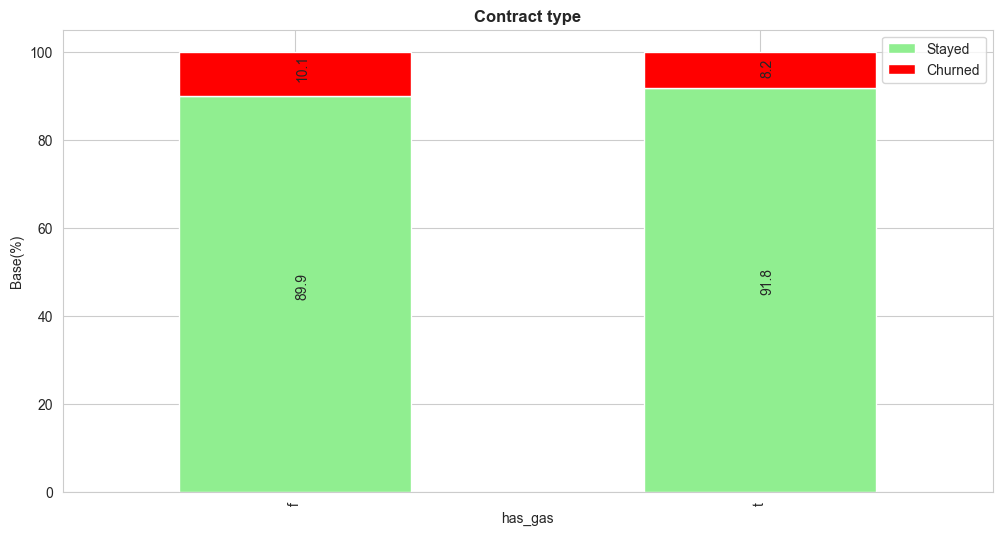

In [100]:
contract_type = client_df[['id', 'has_gas', 'churn']]
contract = contract_type.groupby([contract_type['churn'], contract_type['has_gas']])['id'].count().unstack(level=0)
contract_percentage = (contract.div(contract.sum(axis=1), axis=0) * 100).sort_values(by=[1], ascending=False)
ax = AnnotedBars(contract_percentage, 'Contract type',size=(12,6))

### MARGIN

In [101]:
stayed_margin = client_df[client_df['churn'] == 0][['id','margin_gross_pow_ele','margin_net_pow_ele','net_margin']]
churned_margin = client_df[client_df['churn'] == 1][['id','margin_gross_pow_ele','margin_net_pow_ele','net_margin']]

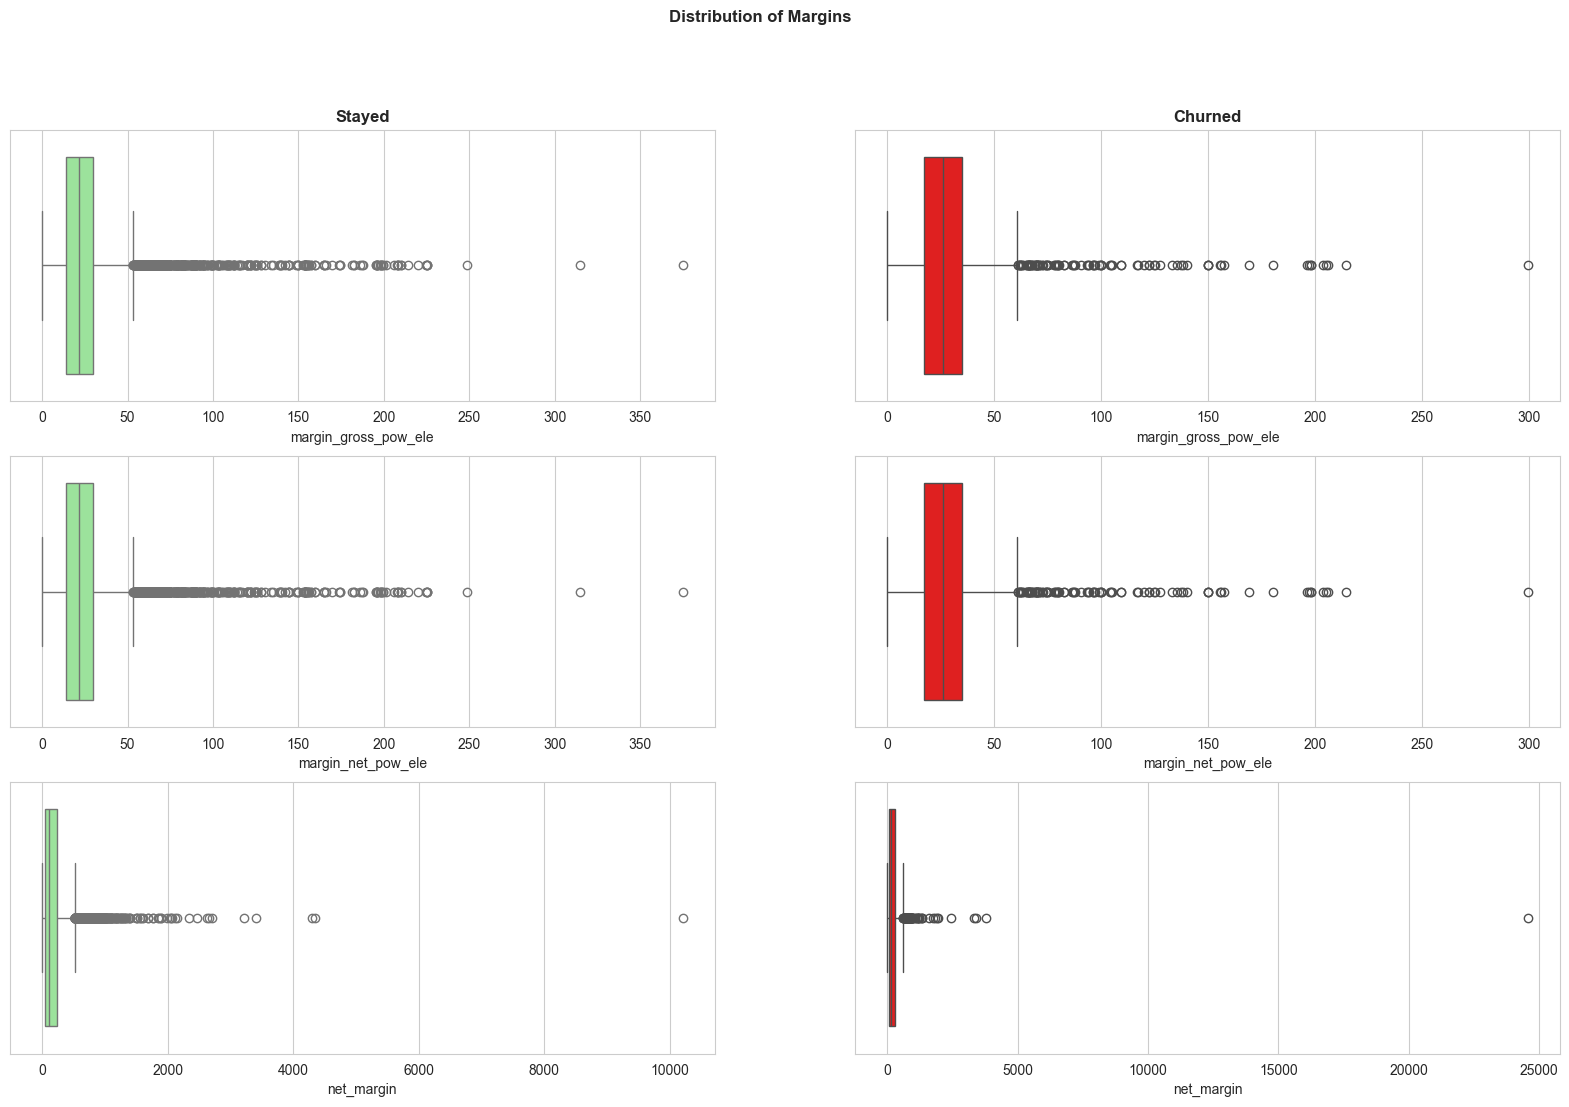

In [102]:
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20,12))
# Plot histogram
sns.boxplot(stayed_margin["margin_gross_pow_ele"], ax=axs[0,0],color='lightgreen',orient='h')
sns.boxplot(stayed_margin["margin_net_pow_ele"],ax=axs[1,0],color='lightgreen',orient='h')
sns.boxplot(stayed_margin["net_margin"], ax=axs[2,0],color='lightgreen',orient='h')
sns.boxplot(churned_margin["margin_gross_pow_ele"], ax=axs[0,1],color='red',orient='h')
sns.boxplot(churned_margin["margin_net_pow_ele"],ax=axs[1,1],color='red',orient='h')
sns.boxplot(churned_margin["net_margin"], ax=axs[2,1],color='red',orient='h')
axs[0,0].set_title('Stayed',fontweight='bold')
axs[0,1].set_title('Churned',fontweight='bold')
plt.suptitle('Distribution of Margins',fontweight='bold')
plt.show()

The margins are also skewedly distributed with extreme outliers we will handle them later.

### OTHER COLUMNS

In [103]:
others = client_df[['id','nb_prod_act','num_years_antig','origin_up', 'churn']]
products = others.groupby([others["nb_prod_act"],others["churn"]])["id"].count().unstack(level=1)
products_percentage = (products.div(products.sum(axis=1), axis=0)*100).sort_values(by=[1], ascending=False)

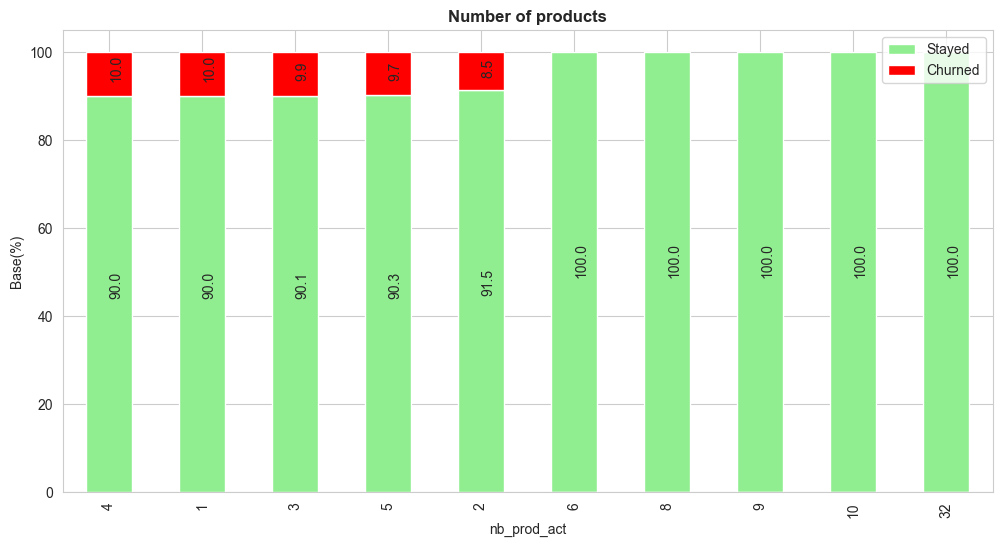

In [104]:
AnnotedBars(products_percentage,"Number of products",size=(12,6))

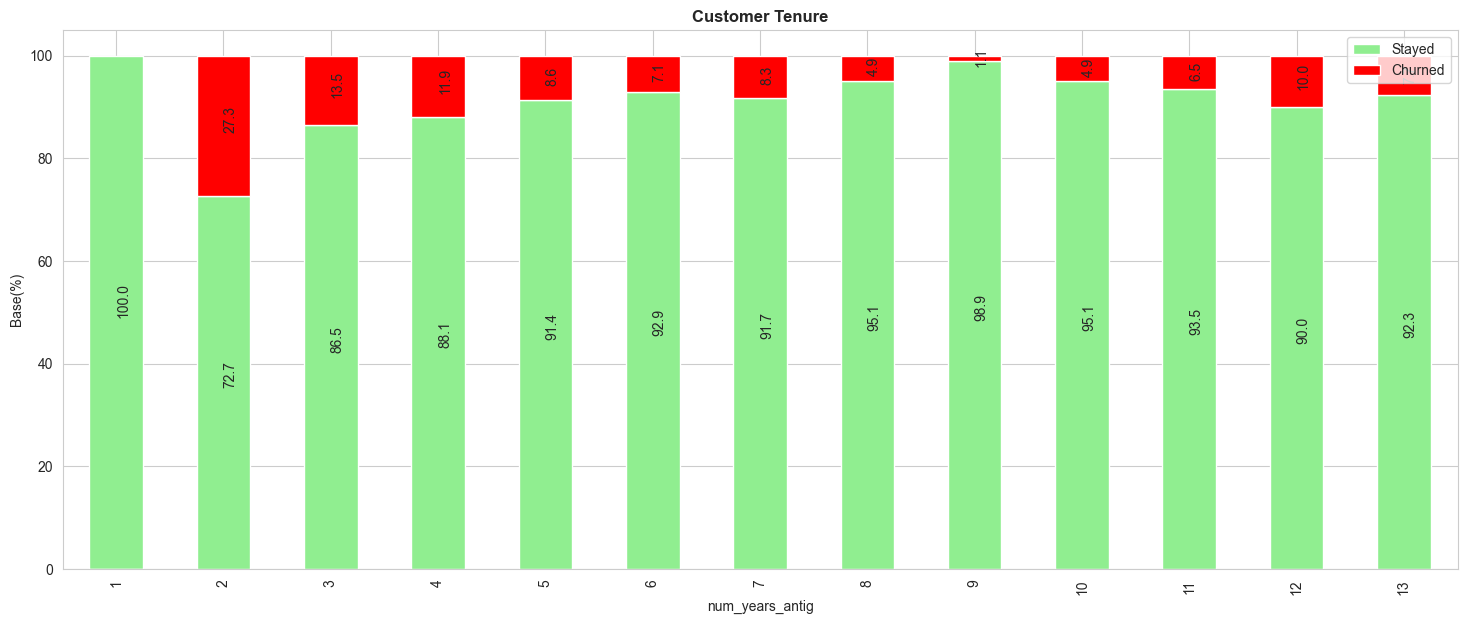

In [105]:
years_antig = others.groupby([others["num_years_antig"],others["churn"]])["id"].count().unstack(level=1)
years_antig_percentage = (years_antig.div(years_antig.sum(axis=1), axis=0)*100)
AnnotedBars(years_antig_percentage,"Customer Tenure",size=(18,7))

The churn rate seems to be highest for second year probably people who didnt like the sevices didnt renewed their contract with company.

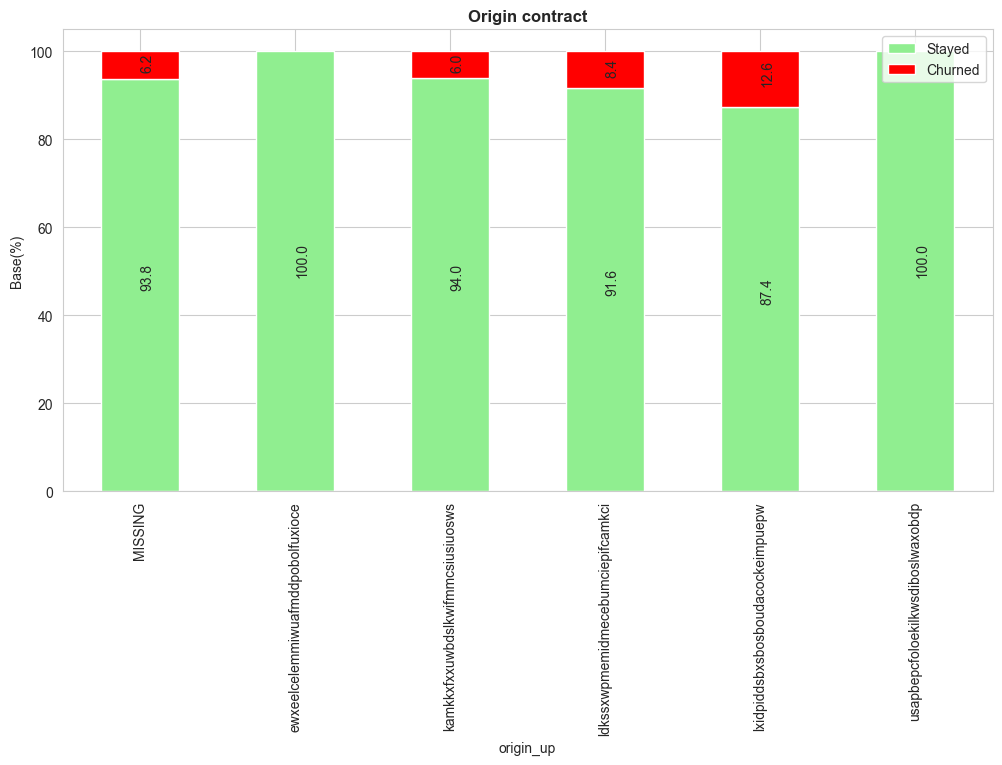

In [106]:
origin = others.groupby([others["origin_up"],others["churn"]])["id"].count().unstack(level=1)
origin_percentage = (origin.div(origin.sum(axis=1), axis=0)*100)
AnnotedBars(origin_percentage,"Origin contract")

### PRICE DISTRIBUTION

In [107]:
fix_price = price_df[['price_off_peak_fix','price_peak_fix','price_mid_peak_fix']]
var_price = price_df[['price_off_peak_var','price_peak_var','price_mid_peak_var']]

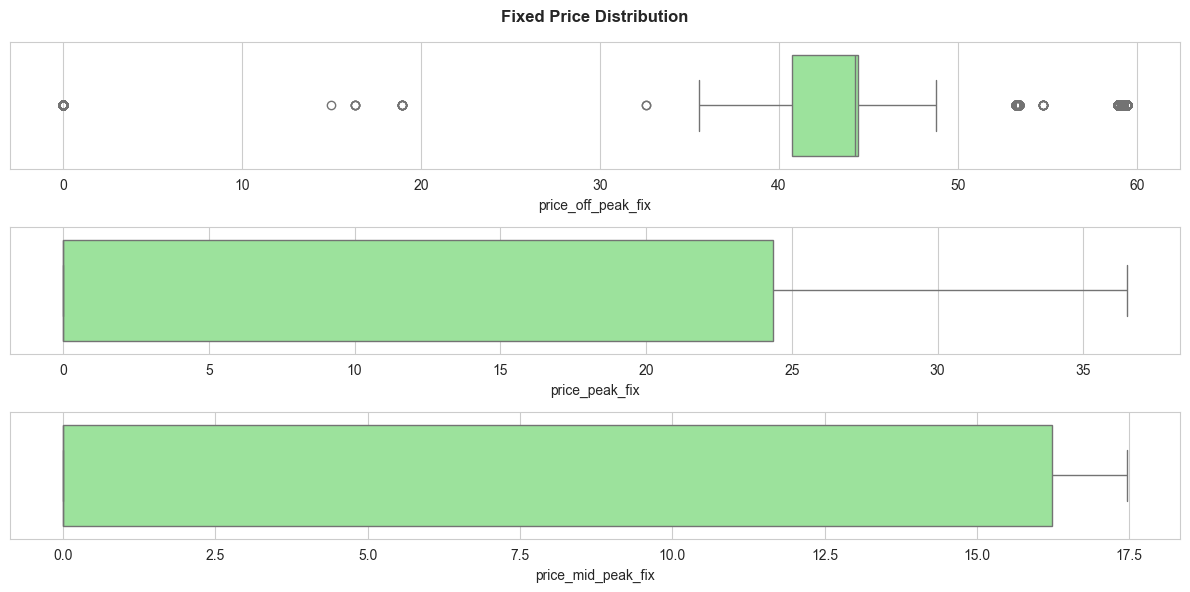

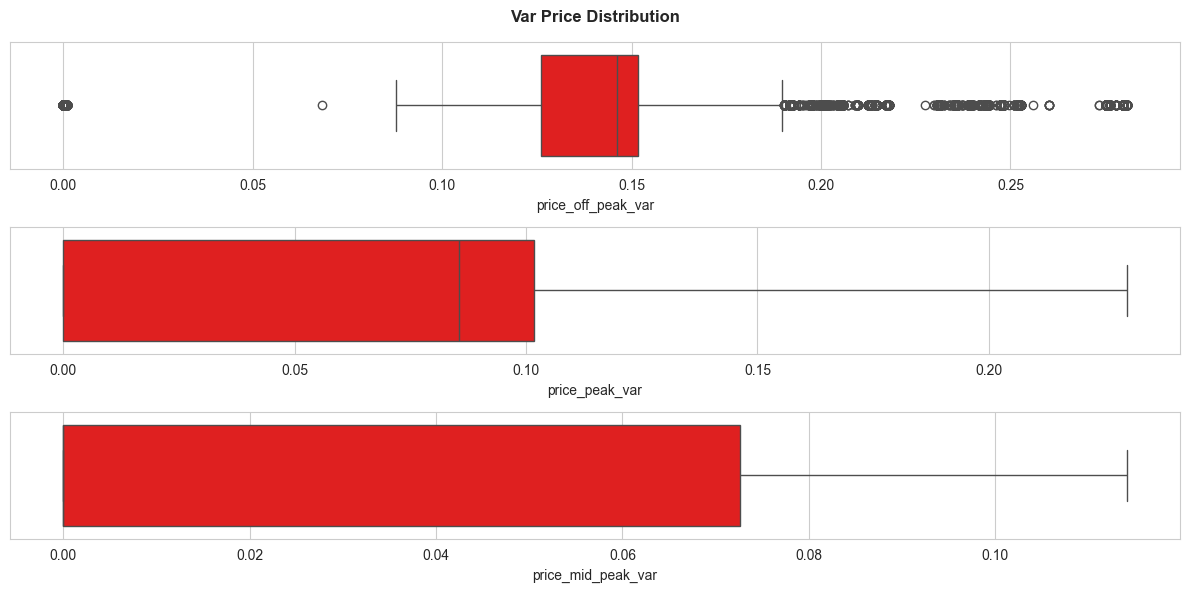

In [108]:
fig,axs = plt.subplots(nrows=3,figsize=(12,6))
for i,col in enumerate(fix_price.columns):
    sns.boxplot(data=fix_price[col],orient='h',ax=axs[i],color='lightgreen')
fig.suptitle('Fixed Price Distribution',fontweight='bold')
plt.tight_layout()
plt.show()

fig,axs = plt.subplots(nrows=3,figsize=(12,6))
for i,col in enumerate(var_price.columns):
    sns.boxplot(data=var_price[col],orient='h',ax=axs[i],color='red')
fig.suptitle('Var Price Distribution',fontweight='bold')
plt.tight_layout()
plt.show()

___
## **FEATURE ENGINEERING**

In this section we will be creating new features by manipulating the existing features which will help us in better predicting the churn of the companies.

We will combine both client and pricing data into one using a left join, taking only the data for which we have client data available and discarding the rest. We will also calculate the average value for each client's pricing data.

In [109]:
# Merging both the df using left join also correcting the data types of all dates columns
df = pd.merge(left=client_df,right=price_df.groupby('id').mean(),on='id',how='left')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')


### DIFFERENCE BETWEEN THE OFF-PEAK PRICES OF DECEMBER AND JANUARY

In [110]:
monthly_price = price_df.groupby(['id','price_date']).agg({'price_off_peak_var':'mean','price_off_peak_fix':'mean'}).reset_index()
jan_price = monthly_price.groupby('id').first().reset_index()
dec_price = monthly_price.groupby('id').last().reset_index()
difference = pd.merge(dec_price.rename(columns={'price_off_peak_var':'dec_var','price_off_peak_fix':'dec_fix'}),
             jan_price.drop(columns='price_date'), on='id')
difference['offpeak_fix_diff_jan_dec'] = difference['dec_fix'] - difference['price_off_peak_fix']
difference['offpeak_var_diff_jan_dec'] = difference['dec_var'] - difference['price_off_peak_var']
difference = difference[['id','offpeak_fix_diff_jan_dec','offpeak_var_diff_jan_dec']]

# Merging feature with orignal dataframe
df = pd.merge(df, difference, on='id')

### AVERAGE PRICE CHANGE ACROSS PERIODS BY COMPANY

In [111]:
avg_prices= price_df.groupby('id').mean().reset_index()

# Calculating the mean difference between consecutive periods
avg_prices['off_peak_peak_var_mean_diff'] = avg_prices['price_off_peak_var'] - avg_prices['price_peak_var']
avg_prices['peak_mid_peak_var_mean_diff'] = avg_prices['price_peak_var'] - avg_prices['price_mid_peak_var']
avg_prices['off_peak_mid_peak_var_mean_diff'] = avg_prices['price_off_peak_var'] - avg_prices['price_mid_peak_var']
avg_prices['off_peak_peak_fix_mean_diff'] = avg_prices['price_off_peak_fix'] - avg_prices['price_peak_fix']
avg_prices['peak_mid_peak_fix_mean_diff'] = avg_prices['price_peak_fix'] - avg_prices['price_mid_peak_fix']
avg_prices['off_peak_mid_peak_fix_mean_diff'] = avg_prices['price_off_peak_fix'] - avg_prices['price_mid_peak_fix']

# Merging features with orignal dataframe
df = pd.merge(df,avg_prices.iloc[:,[0]+list(range(7,avg_prices.shape[1]))],on='id')

### MAX PRICE CHANGE ACROSS PERIODS & MONTH


I am adding this after considering the consumer's perspective, as sudden price changes between months can be quite frustrating. A significant price increase in a short time frame can drive customers to explore alternatives, ultimately leading to churn.

In [112]:
avg_monthly_prices = price_df.groupby(['id','price_date']).mean().reset_index()

# Calculating Avg for each company across price date
avg_monthly_prices['off_peak_peak_var_mean_diff'] = avg_monthly_prices['price_off_peak_var'] - avg_monthly_prices['price_peak_var']
avg_monthly_prices['peak_mid_peak_var_mean_diff'] = avg_monthly_prices['price_peak_var'] - avg_monthly_prices['price_mid_peak_var']
avg_monthly_prices['off_peak_mid_peak_var_mean_diff'] = avg_monthly_prices['price_off_peak_var'] - avg_monthly_prices['price_mid_peak_var']
avg_monthly_prices['off_peak_peak_fix_mean_diff'] = avg_monthly_prices['price_off_peak_fix'] - avg_monthly_prices['price_peak_fix']
avg_monthly_prices['peak_mid_peak_fix_mean_diff'] = avg_monthly_prices['price_peak_fix'] - avg_monthly_prices['price_mid_peak_fix']
avg_monthly_prices['off_peak_mid_peak_fix_mean_diff'] = avg_monthly_prices['price_off_peak_fix'] - avg_monthly_prices['price_mid_peak_fix']
max_diff_across_periods_months = avg_monthly_prices.iloc[:,[0]+list(range(8,avg_prices.shape[1] + 1))].groupby('id').max().reset_index()
# Renaming the columns from mean to max
for col in max_diff_across_periods_months.columns.to_list():
    new_col = col.replace('mean','max')
    max_diff_across_periods_months.rename(columns={col:new_col},inplace=True)

# Merging with origbal dataset
df = pd.merge(df, max_diff_across_periods_months, on='id')

### TENURE

The tenure of a customer with the company can be a key determining factor when viewed from the customer’s perspective. Over time, customers build trust and relationships with companies, and their continued loyalty suggests they are satisfied with the services provided. On the other hand, those who are dissatisfied are more likely to churn.

In [113]:
# Tenure in years
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1,'Y')).astype(int)

### DATES INTO MONTHS

Since dates cannot be directly used as features in a classification model,it’s more effective to convert them into continuous or categorical values,such as the number of months or days from a reference date.

For example, if a contract is due for renewal next month, the customer might explore alternative options, making this a crucial feature for predicting churn.On the other hand, the likelihood of churn just after signing a contract is typically lower,as the company has already incurred acquisition costs.Another important factor could be if a customer recently modified their contract,as this may indicate satisfaction with the service or at least a level of engagement with the company.

In [114]:
df['date_end'].min().date()
# Function to convert the dates into months
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [115]:
# Selecting the 1 jan 2016 to be the reference date

reference_date = pd.Timestamp(2016, 1, 1)
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [116]:
# Removing all the date columns as we dont need them anymore
date_columns = df.select_dtypes(include=['datetime64']).columns
df = df.drop(columns=date_columns)

### ENCODING CATEGORICAL COLUMNS

Machine learning models do not understand words or text directly,as they work by generating mathematical equations that use numerical features and coefficients to make predictions.To predict outcome,we need to convert textual data into numerical form,so the model can process it and learn meaningful patterns from it.

In [117]:
df.select_dtypes('object').columns

Index(['id', 'channel_sales', 'has_gas', 'origin_up'], dtype='object')

Since id has no predictive value we will encode just 'channel_sales','has_gas','origin_up'

In [118]:
# GAS CONTRACT
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])

For other two columns we wil be using one hot encoding since the features channel_sales and origin dont show any hierarchy otherwise we will use the nominal endoding.

In [119]:
# SALES CHANNEL
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

We can see that the last three channels have very few occurrences 11,3, and 2 out of approximately 13,000–14,000 rows.Since their corresponding dummy columns will contain mostly zeros,they add very little value to the model. To avoid increasing the dimensionality of the dataset unnecessarily and reduce the risk of overfitting,we will drop these columns.

In [120]:
df = pd.get_dummies(data=df,columns=['channel_sales'],prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])

In [121]:
# ORIGIN CONTRACT/CAMPAIGN
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similar to above cases dropping last 3 including that 'Missing' column due to fewer occurences.

In [122]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])

### TRANSFORMING SKEWED DATA

As we saw earlier,many of our features are skewed and contain outliers.Handling these through transformation is crucial because the model assumes normally distributed data and minimal multicollinearity(correlation among features).Without transforming the data, these issues can distort the model and negatively impact its overall performance.

For our data transformation, we will use the logarithmic (log) transformation. This method is particularly effective for our dataset because:
1. Our data doesn't contain any negative values, which is a requirement for log transformation.
2. Many of our features are highly skewed towards the right (positively skewed).



In [123]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00
mean,159220.29,28092.38,16090.27,1868.61,1399.76,0.97,63.09,0.14,0.05,43.13
std,573465.26,162973.06,64364.20,2387.57,3247.79,5.11,66.17,0.02,0.05,4.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,5674.75,0.00,0.00,495.00,0.00,0.00,16.18,0.12,0.00,40.61
50%,14115.50,0.00,792.50,1112.88,314.00,0.00,18.80,0.14,0.08,44.31
75%,40763.75,0.00,3383.00,2401.79,1745.75,0.00,131.03,0.15,0.10,44.31
max,6207104.00,4154590.00,771203.00,82902.83,175375.00,30.00,599.31,0.27,0.20,59.27


We can see that all these variables are skewed with high standard deviation

In [124]:
# Adding 0 as the log(0) is undefined
for col in skewed:
    df[col] = np.log10(df[col] + 1)
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00,14606.00
mean,4.22,0.78,2.26,2.96,1.78,0.05,1.52,0.06,0.02,1.64
std,0.88,1.72,1.77,0.68,1.58,0.27,0.57,0.01,0.02,0.13
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.75,0.00,0.00,2.70,0.00,0.00,1.24,0.05,0.00,1.62
50%,4.15,0.00,2.90,3.05,2.50,0.00,1.30,0.06,0.04,1.66
75%,4.61,0.00,3.53,3.38,3.24,0.00,2.12,0.06,0.04,1.66
max,6.79,6.62,5.89,4.92,5.24,1.49,2.78,0.11,0.08,1.78


We can see now that the deviation has been reduced

Checking the other variables distribution now

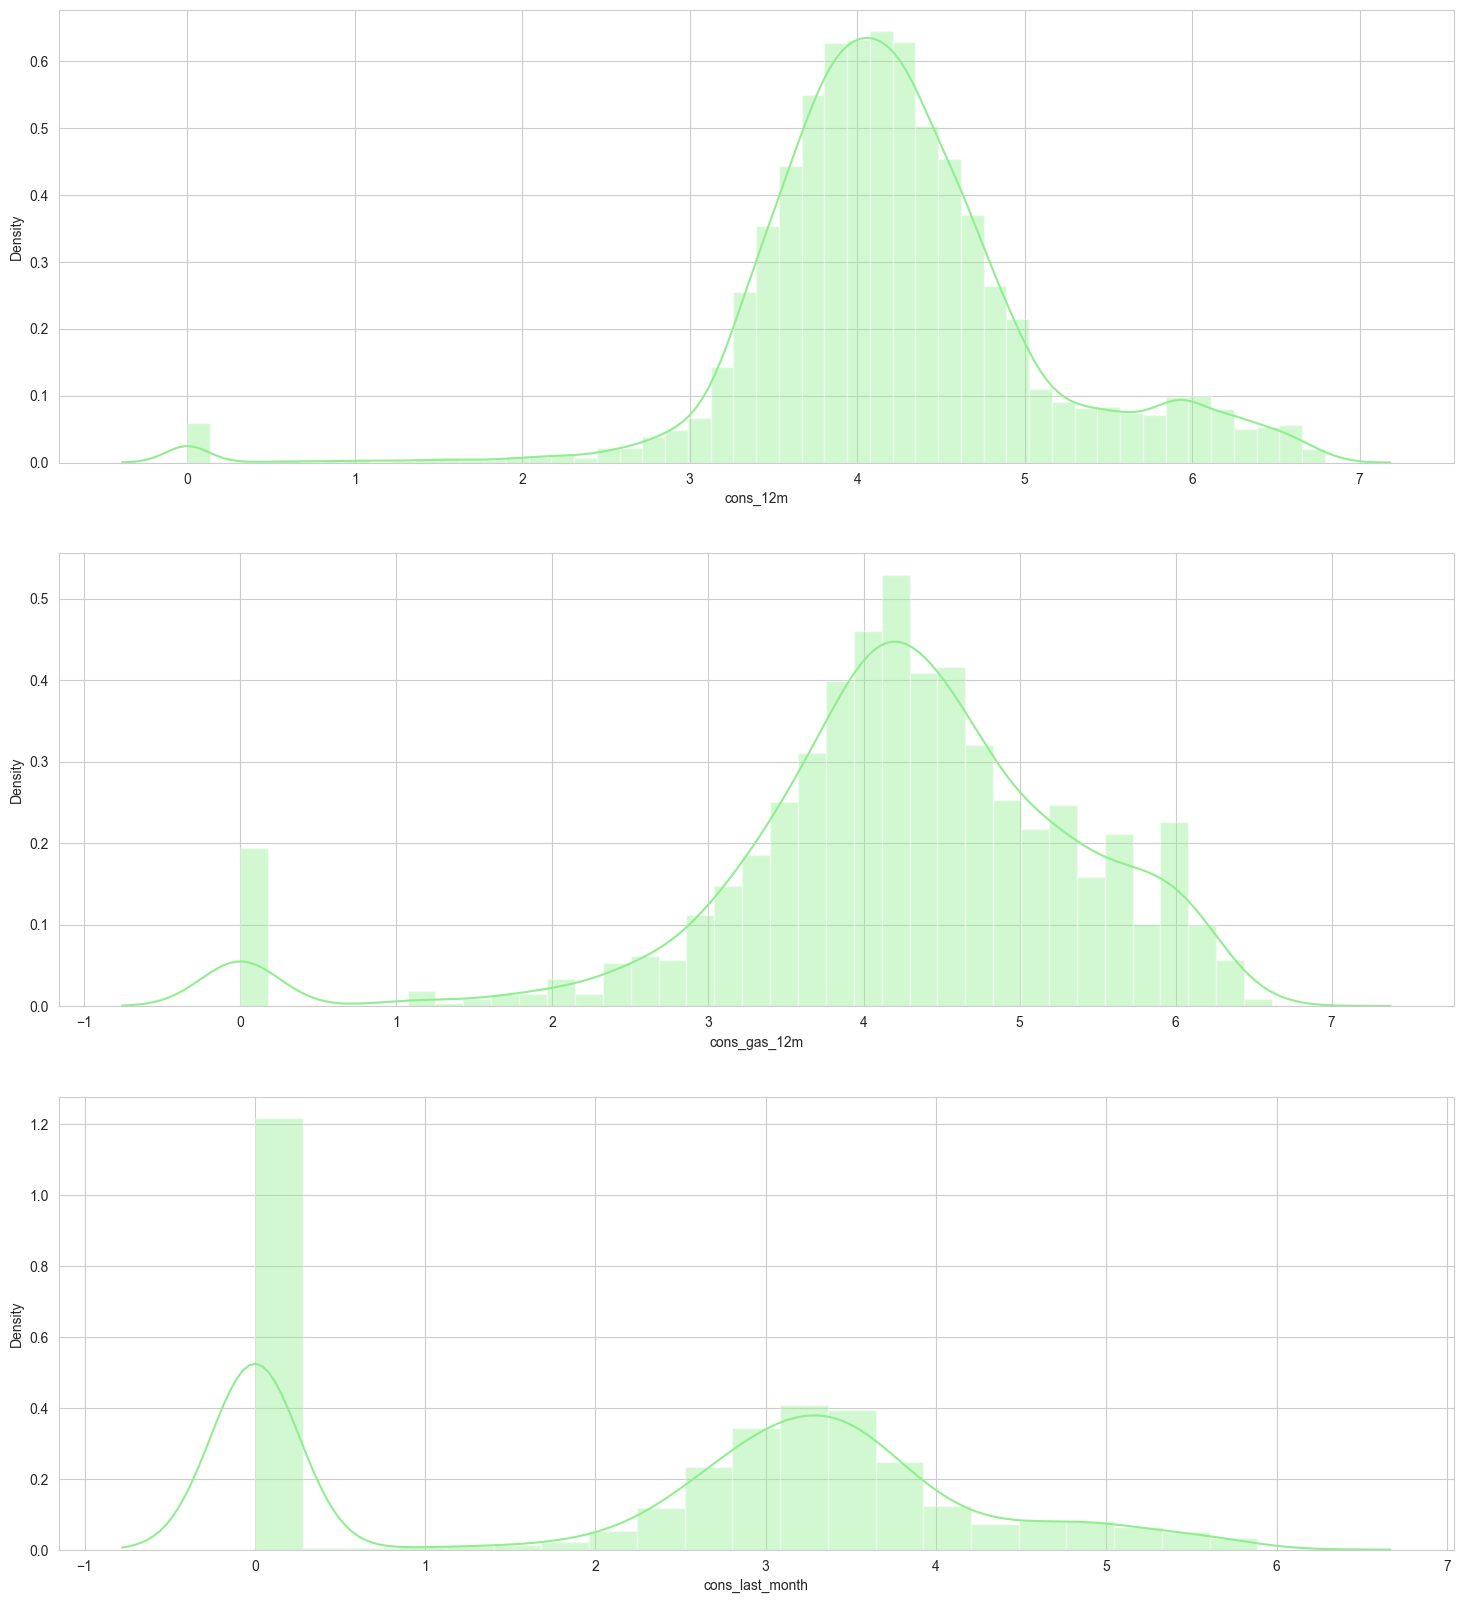

In [125]:
fig, axs = plt.subplots(nrows=3,figsize=(18, 20))
sns.distplot((df["cons_12m"].dropna()),ax=axs[0],color='lightgreen')
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()),ax=axs[1],color='lightgreen')
sns.distplot((df["cons_last_month"].dropna()),ax=axs[2],color='lightgreen')
plt.show()

We can observe that the data has been normalized to a major extent, following a bell curve

### MITIGATING MULTICOLLINEARITY 

Multicollinearity refers to high correlation amongst the input variables, breaking the assumption of independent features. It highlights that these variables share similar information, potentially leading to redundancy in the model.

There are many ways to mitigate multicollinearity:
1. Remove highly correlated features
2. Combine correlated features using dimensionality reduction techniques like PCA

We will remove the features which are highly correlated and then move to supervised learning techniques like Principal Component Analysis (PCA) since the process of feature engineering is iterative so we can always come back.


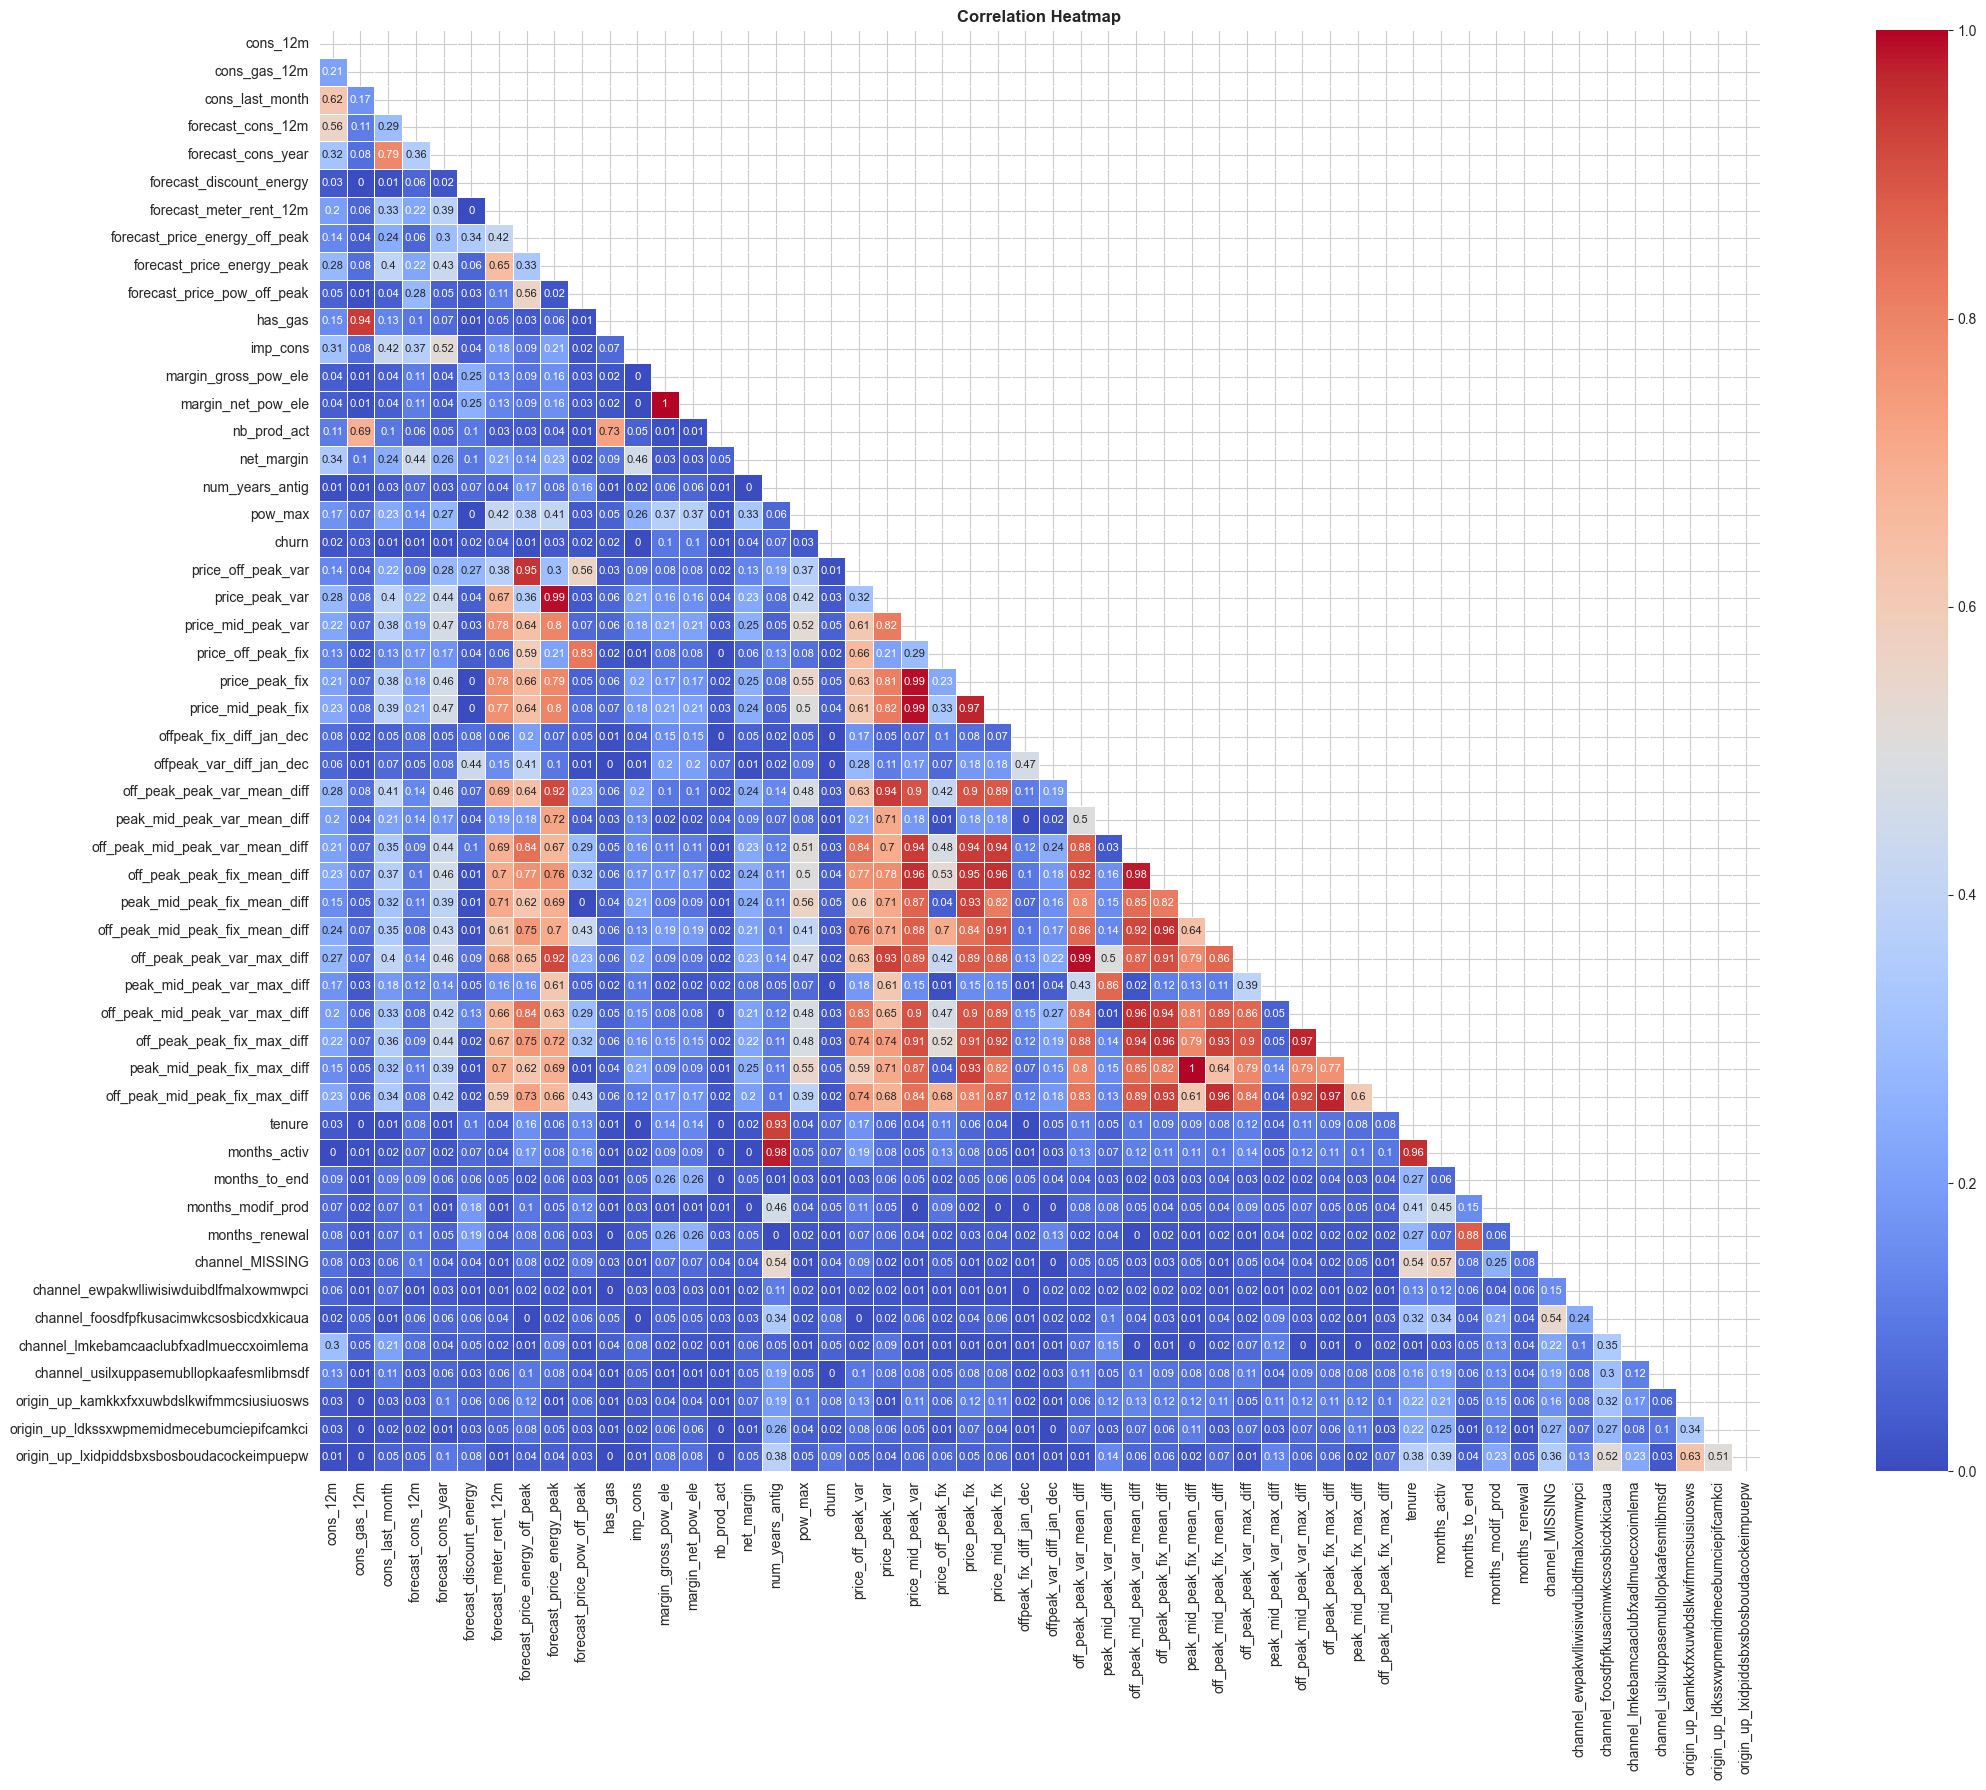

In [126]:
# Selecting the numerical columns and removing the churn column from them as it is target variable
corr_matrix = round(df.corr().abs(),2)
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(25, 18))
colors = ["red", "lightgreen"]
# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
            linewidths=0.5, annot_kws={'size': 8}, square=True)

plt.title('Correlation Heatmap',fontweight='bold')
plt.tight_layout()


In [127]:

# Find columns with correlation > 0.9
columns_to_drop = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname = corr_matrix.columns[i]
            if colname not in columns_to_drop:
                columns_to_drop.append(colname)

# Save the columns before dropping
deleted_columns = df[columns_to_drop].copy()

# Print the columns that will be dropped
print("Columns to be dropped due to high correlation:")
print(columns_to_drop)


Columns to be dropped due to high correlation:
['has_gas', 'margin_net_pow_ele', 'price_off_peak_var', 'price_peak_var', 'price_peak_fix', 'price_mid_peak_fix', 'off_peak_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff', 'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff', 'off_peak_peak_var_max_diff', 'off_peak_mid_peak_var_max_diff', 'off_peak_peak_fix_max_diff', 'peak_mid_peak_fix_max_diff', 'off_peak_mid_peak_fix_max_diff', 'tenure', 'months_activ']


We can see that highly correlated features have been removed, so now we can move on to training our model

___
## **MODEL TRAINING AND EVALUATION**

### DATA SAMPLING

In [128]:
y = df['churn']
X = df.drop(columns=['id','churn'])
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0) # Using 80% data to train and rest 20% to test
y.value_counts() # Checkng total instances of both Churn and Non-Churn customers to find any class imbalances

0    13187
1     1419
Name: churn, dtype: int64

We can clearly see that the dataset is imbalanced here: **13187 instances of Stayed Customers** and only **1419 instances of Churned**.I will not address the imbalance at this stage, but if I observe poor model performance, I may consider handling it later.

### MODEL TESTING

We are using the LazyPredict library's LazyClassifier class to initially test multiple models on our dataset,after that,we will use k-fold cross-validation to evaluate the top 5 performing models more thoroughly.We will then select the best model based on these cross-validation results.We then will finetune the hyperparameters of the model to improve the performance


In [129]:
# Creating a function to measure F1 score of the churned class
def class_1_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1, average='binary')

# Making a custom scorer object to use for evaluating the models during k-fold cross-validation
custom_scorer = make_scorer(class_1_f1_score)

# Using class_1_f1_score to filter the best classifier for our dataset
classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=class_1_f1_score)
models, predictions = classifier.fit(X_train, X_test, y_train, y_test)

# Initializing a list to store models and their metrics (Top 5)
cv_results = []

# Iterating through the models DataFrame to pick name of each model
for model_name in models.index:
    # Extracting the model object using its naem
    model = classifier.models[model_name]
    
    # Perform cross-validation
    cv_scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, scoring=custom_scorer)
    
    # Append results
    cv_results.append({
        'Model': model_name,
        'Mean CV F1-Score (Class 1)': cv_scores.mean()
    })

# Converting the list into a dataframe and sorting based on class 1 F1 score
cv_df = pd.DataFrame(cv_results).sort_values('Mean CV F1-Score (Class 1)',ascending=False)

# Get the best model name
best_model_name = cv_df.iloc[0]['Model']
print(f'The best model identified after the K-fold validation for our dataset is: {best_model_name}')

 97%|█████████▋| 30/31 [00:52<00:01,  1.03s/it]

[LightGBM] [Info] Number of positive: 1169, number of negative: 10515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7400
[LightGBM] [Info] Number of data points in the train set: 11684, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100051 -> initscore=-2.196654
[LightGBM] [Info] Start training from score -2.196654


100%|██████████| 31/31 [00:53<00:00,  1.71s/it]


[LightGBM] [Info] Number of positive: 935, number of negative: 8412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7325
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100032 -> initscore=-2.196868
[LightGBM] [Info] Start training from score -2.196868
[LightGBM] [Info] Number of positive: 935, number of negative: 8412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7326
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100032 -> initscore=-2.196868
[LightGBM] [Info] Start training from score -2.196868
[LightGBM] [Info] Nu

As we can see the XGBoost classifier has emerged as the best model for our case.XGBoost stands for extreme gradient boosting and works on the same principle of ensemble learning,similar to models like Random Forest.It combines the output of individual trees but differs from Random Forest as it sequentially builds trees where each tree aims to correct the errors of the previous weak learner tree,thereby improving accuracy progressively.


XGBoost Classifier Metrics:
Accuracy: 0.9206
Precision: 0.6406
Recall: 0.1640
F1-Score: 0.2611


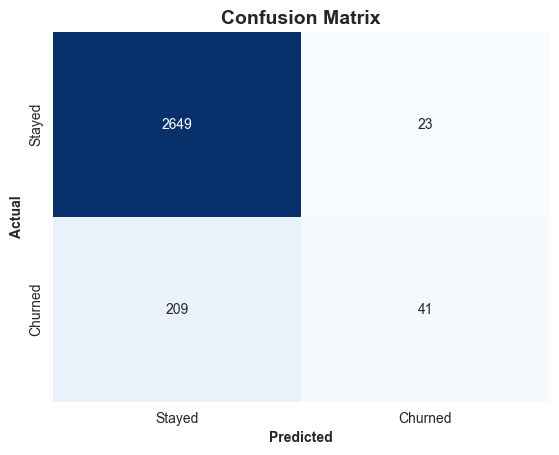

In [130]:
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_pred = (y_pred_proba >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Printing all the metrics
print("XGBoost Classifier Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plotting the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['Stayed', 'Churned'])
plt.yticks(ticks=[0.5, 1.5], labels=['Stayed', 'Churned'])
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show()


### EVALUATION

<mark>Accuracy:</mark> This indicates that **92.06%** of all the predictions were correct, though seems good it can be misleading specially in imbalanced dataset like ours, so we need to like at other metrics get a comprehensive understanding of the model.

<mark>Precision:</mark> This indicates that **64.06%** of the customers predicted to churn did indeed churn. This suggests that while the model is somewhat reliable in identifying potential churners, there is still a significant proportion (approximately 35.94%) of false positives, where customers were incorrectly labeled as likely to churn. This could lead to potentially unnecessary or misdirected retention efforts targeted at these customers. There is alot of scope of improvement a good precison score is said to be aroun 85-90%.

<mark>Recall:</mark> The recall is around **16%**, indicating that out of all actual churned customers (True Positives), our model was only able to identify 16%, missing almost 84% of customers who actually churned. This should be our main concern, as in the case of churn the most important factor is to correctly identify those who will churn. Failing to identify these customers may result in losing them.

<mark>Confusion Matrix:</mark> I have simplified by naming positives and negatives and churned and stayed we can see that we are able to identify those who wull not churn around **2649** customers and only missed on around **23** but in case of churn we missed on almost **209** customers which is a huge problems and needs to be addressed.

<mark>Potential Cause:</mark> As observed in our training dataset, there is a **class imbalance** with a predominant **'stayed'** class and a minority **'churned'** class alos telling us that the present fearures in the dataset may nor be discriminarive enough to correctly distinguish between those who stayed and those who churnd.

<mark>Solution:</mark> We can revisit the feature engineering stage and consider using techniques like **Principal Component Analysis (PCA)** to create new features. Additionally, we can explore methods such as **undersampling the majority class** or **oversampling the minority class** or **adjusting the weights given to each class** to address the class imbalance issue.

**For now we will try to understand our model little more deeply.**

In [ ]:
# Saving the model as a joblib object for future use

# Remove '#' to save the model
joblib.dump(value=model,filename='Model/xgb_model.joblib')


In [ ]:
# Saving the predictions in a csv file

# Remove the '#' to save the predictions.csv file
# predictions_df.to_csv('Output/predictions.csv',index=False)

### FEATURE IMPORTANCE AND MODEL EXPLAINATION

First,we will assess the importance of each feature based on how much it contributes to the model's predictions.The more important a feature is, the higher its weight or coefficient in the mathematical equation of the model. Later,we will use the SHAP (Shapley additive explainations) library to explain why a particular individual is predicted as "stayed" or "churned."

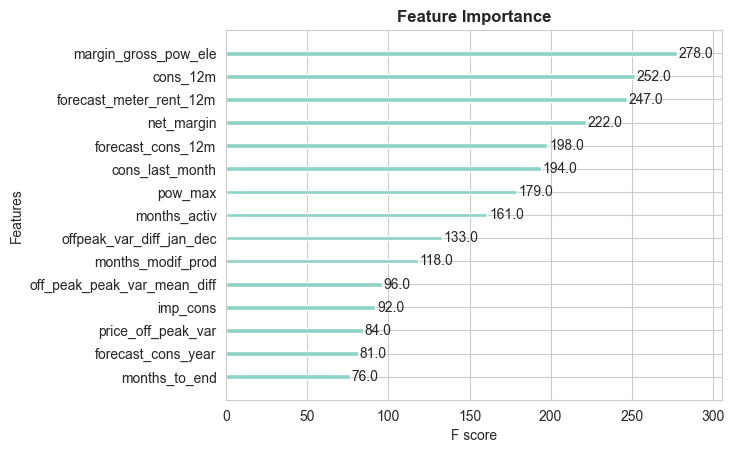

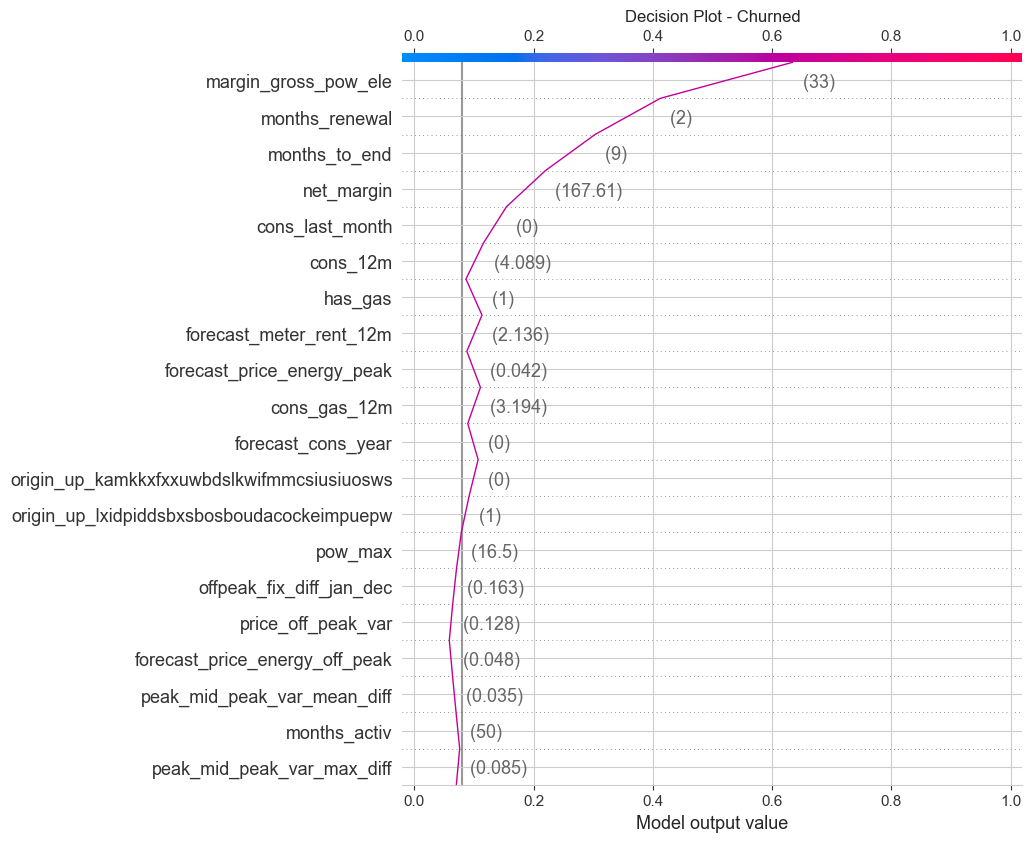

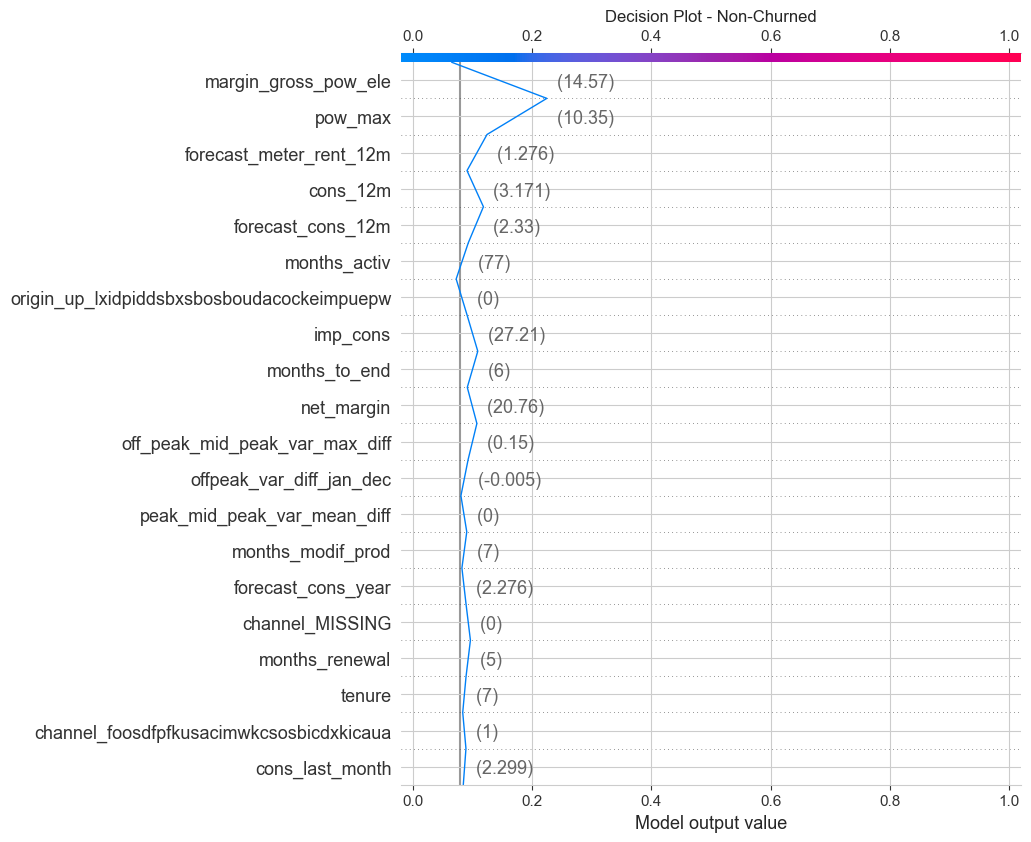

In [132]:
# Plotting importance of each feature
plot_importance(model, max_num_features=15)
plt.title('Feature Importance',fontweight='bold')
plt.show()

# Initialize SHAP values using the TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculating shap values of x_test
shap_values = explainer.shap_values(X_test)

# Creating an index mapping dictionary so that we can use the relative position of the index in different places
index_mapping = {original_index: i for i, original_index in enumerate(X_test.index)}

# Function to plot SHAP decision plot
def plot_shap_decision(index, label):
    # Getting the position in x_test
    position = index_mapping[index]
    shap.decision_plot(
        explainer.expected_value,
        shap_values[position],
        features=X_test.iloc[position],
        feature_names=X_test.columns.to_list(),
        link='logit',title=f'Decision Plot - {label}',
    )
    plt.show()

# Taking one correctly cases of each class
churned_index = y_test.index[(y_pred == 1) & (y_test == 1)][0]
stayed_index = y_test.index[(y_pred == 0) & (y_test == 0)][0]
plot_shap_decision(churned_index, 'Churned')
plot_shap_decision(stayed_index, 'Non-Churned')



**`F-score`**- It is a metric used in decision tree models to indicate how often a feature is used to split the data across all the trees in the model, with a higher score showing greater importance in predicting the outcome.
we will be using this metric to understand the importance of each feature in predicting the customer status.

From the **`Feature Importance plot`**, we can observe the determining factors in prediction of customer status:

The most crucial factor in determining churn status, based on this model, is **margin_gross_pow_ele**, which indicates the gross margin on power subscriptions, with an F-score of **278**. Following this is **cons_12m**, representing the electricity consumption of the past 12 months, with an F-score of **252**. The third most important feature is **forecast_meter_rent_12m**, which forecasts the bill for meter rentals over the next 12 months, with an F-score of **247**. The fourth key feature is **net_margin**, which refers to the overall profitability of each customer, with an F-score of **222**. The fifth most significant feature is **forecast_cons_12m**, the forecasted electricity consumption for the next 12 months scoring **198** F-score.

Although our original hypothesis suggested that customers may be churning due to price sensitivity, none of the top five features in the model are directly related to price. However, **offpeak_var_diff_jan_dec** ranks ninth in importance, with an F-score of **133**, and **offpeak_peak_var_mean_diff** ranks eleventh, with an F-score of **96**. This indicates that while price may influence churn, it is not the primary driver.The main determining factors are consumption and margin, suggesting that price sensitivity plays a secondary role in customer churn.

We are using the **`Decision Plots`** to understand why a particular customer has been classified as churned or stayed:

#### **Churned Instance:**

- `margin_gross_pow_ele` has the highest positive impact on classifying the instance as churned, indicating probably that high gross margin on power is associated with churn.

- `months_renewal`, `months_to_end` our contract-related features that we created during feature engineerinf also play a crucial role in classifying the instance as churn. Customers nearing the end of their contract or with upcoming renewal dates has high chances of churning.

- `net_margin` similar to gross margin, this is another margin-related feature pushing towards churn.

- `cons_last_month` and `cons_12m` these consumption related features also seems influence the model to classify the instance as churn in this case we can see that the last month consumption of the customer is **0** so he is classified ss churn.

There are many other features contributing smaller impacts, like **gas subscription**, **different forecasts**, but these seem to have relatively marginal effects.

#### **Non-Churned Instance:**

- `margin_gross_pow_ele` Interestingly, this feature appears again but has a negative impact here, pushing the model towards a non-churn decision. It could mean that lower margin customers are less likely to churn.

- `pow_max` this feature reppresenting subscribed power also has a significant impact on reducing the likelihood of churn.

- `forecast_meter_rent_12m` and `cons_12m` these features related to past 12 month power consumption and forecasted meter rent of next 12 months also contribute to reducing churn likelihood.

- `months_activ`: Customers who have been active longer are less likely to churn probably due to a sense of loyalty and relation that they has built with company may be due to they were getting better services and are satisfied with it.

#### **Final Conclusion**

Based on the above analysis, we can conclude that price sensitivity is not the primary factor driving customer churn. Instead, we can assert that churn is primarily influenced by margin and consumption-related factors. Here, margin refers to the company's profitability on the services provided, not implying that high margin means customers are being charged high prices. While price sensitivity does play a role, it is not the main cause of customer churn, as evidenced by the feature importance and decision plots. The analysis indicates that higher margins and specific consumption patterns are more critical in determining customer behavior.



___
# <center>**CONCLUSION AND ACHIEVEMENTS**</center>
___

- **Data Exploration and Preparation:**
The project began with a comprehensive exploratory data analysis (EDA) on two datasets customer data and price data—to understand key characteristics.
Null values were checked and data types were corrected,particularly for date columns. Descriptive statistics and visualizations helped uncover patterns in consumption, contract type (gas vs. no gas), margins, and price distribution.

- **Feature Engineering:**
New features were created by merging customer data with price data, calculating average price changes across periods, and developing variables related to contract tenure and price differences between peak and off-peak periods.
Skewed features were transformed using logarithmic techniques to normalize the data.

- **Model Training:**
Several machine learning models were tested using LazyPredict to identify the most promising model.
**XGBoost** was selected as the best-performing model from top 5 models providing the highest recall for Churn, after performing cross-validation on top 5 performers.
The model was evaluated based on precision, recall, accuracy, and F1-score.

- **Model Interpretation:**
Feature importance was analyzed using SHAP (SHapley Additive exPlanations) to explain the reasons behind the model's predictions.
The key features driving churn were identified as **margins** and **consumption patterns**, rather than price sensitivity.

#### **ACHIVEMENTS**

- **Data-Driven Insights:**
The project successfully pinpointed key factors contributing to customer churn, helping to prioritize retention strategies more effectively.

- **Model Performance:**
The XGBoost model achieved an accuracy of 92%, though recall for churned customers remained low, highlighting room for improvement in identifying potential churners.

- **Feature Interpretability:**
The SHAP-based model interpretation provided a clear understanding of the factors that contribute to customer churn, enabling better decision-making for the business.

By addressing these key aspects, the project provides actionable insights into customer behavior and lays the groundwork for improving customer retention strategies.

___
# <center>**ACKNOWLEDGEMENTS AND NOTES**</center>
___

**Created by**: Krishna Kasera    
**Email**: kkasera025@gmail.com

### **`NOTE:`**
This project was developed by me as a part of the BCG X Data Science & Analytics Virtual Experience Program on Forage. While the analysis was originally conducted in three separate phases - Exploratory Data Analysis, Feature Engineering, and Model Training & Evaluation - they have been consolidated into a single comprehensive document to provide a more cohesive reading experience.


### **`ACKNOWLEDGEMENTS:`**
I would like to express my sincere gratitude to BCG X for providing this enriching virtual experience program. I also extend my thanks to the Forage platform for hosting this job simulation and to the open-source community for creating and providing the various libraries I used for the analysis.


